In [45]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import gwpopulation
from gwpopulation.models.redshift import MadauDickinsonRedshift
import bilby
import seaborn as sns
import pylab as plt
import os
import h5py
from sympy import symbols
import GWForge
import pycbc
import numpy as np
from scipy.signal import argrelextrema
import pandas as pd

# A-sharp

In [46]:
project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'

#mass_band = 'below_40'
#mass_band = '40-80'
mass_band = 'above_80'

run_dir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 'Asharp',
                       'mass_bands', mass_band, 'run11_gwfish_MDlow_mf_from_gaussian_SNR_injections_XPHM',)
#run_dir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 'Asharp', 
#                       'run19_gwfish_MDlow_mf_from_gaussian_SNR_injections_XPHM')

In [47]:
gwpop_result = bilby.result.read_in_result(filename=os.path.join(run_dir,
                                                                 'Asharp_result.hdf5'))
posterior_mf = gwpop_result.posterior

In [48]:
posterior_mf

,gamma,kappa,log_likelihood,log_prior,z_peak
0,2.641101,3.412707,1706.909753,-5.857933,0.881791
1,0.091213,16.181106,1708.959396,-5.857933,3.820589
2,0.559700,7.811529,1709.767693,-5.857933,2.407787
3,1.077437,5.837736,1710.240011,-5.857933,1.534660
4,1.770763,6.554946,1710.285860,-5.857933,1.675831
...,...,...,...,...,...
2915,3.647681,5.187512,1717.500502,-5.857933,0.528602
2916,3.562028,5.039551,1717.514450,-5.857933,0.503906
2917,4.100622,5.579561,1717.523878,-5.857933,0.519613
2918,4.185501,5.719193,1717.523906,-5.857933,0.514594


In [49]:
if 'MDlow' in run_dir:
    inj_pop = '5_pop_PLP_spin_prec_fref_10_z_MDlow_zp_1.54_zmax_10_lmrd_22_365_days_corrected_td.h5'
elif 'MDhigh' in run_dir:
    inj_pop = '4_pop_PLP_spin_prec_fref_10_z_MDhigh_zp_2.53_zmax_10_lmrd_22_365_days_corrected_td.h5'
else:
    inj_pop = '2_pop_PLP_spin_prec_fref_10_z_MD_zmax_10_lmrd_22_365_days_corrected_td.h5'
with h5py.File(os.path.join(project_dir, 
                            'input_population', 
                            'BBH', 
                            inj_pop), 'r') as f:
    injected_redshift = f['redshift'][:]
print(inj_pop)

5_pop_PLP_spin_prec_fref_10_z_MDlow_zp_1.54_zmax_10_lmrd_22_365_days_corrected_td.h5


## Plot injected data

Text(0.5, 0, '$z$')

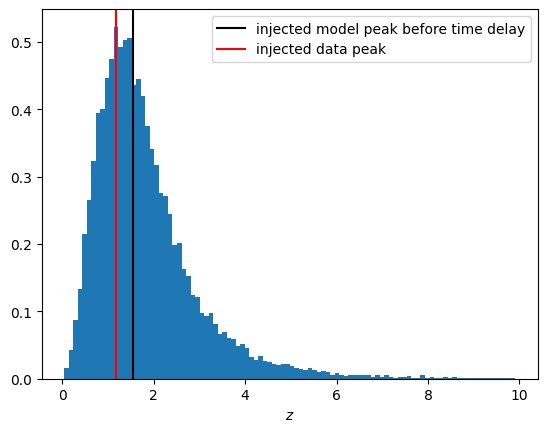

In [50]:
if 'MDhigh' in run_dir:
    inj_peak = 2.53
elif 'MDlow' in run_dir:
    inj_peak = 1.54
else:
    inj_peak = 1.9
plt.hist(injected_redshift, bins=100, density=True);
plt.axvline(inj_peak, c='k', label='injected model peak before time delay')
hData = np.histogram(injected_redshift, bins=100)
inj_z_peak_edge_idx = np.argmax(hData[0])
inj_z_peak = (hData[1][inj_z_peak_edge_idx] + hData[1][inj_z_peak_edge_idx + 1])/2
plt.axvline(inj_z_peak, c='r', label='injected data peak')
plt.legend()
plt.xlabel('$z$')

## Rebuild MDR model

In [51]:
MDR_model = MadauDickinsonRedshift(z_max=10)

In [52]:
if 'MDhigh' in run_dir:
    injected_hyper_params = {'before_time_delay':{"gamma": 2.7, "kappa": 5.6, "z_peak": 2.53}, 
                             'after_time_delay':{'gamma':1.7982, 'kappa':5.3226, 'z_peak':2.4199}}
elif 'MDlow' in run_dir:
    injected_hyper_params = {'before_time_delay':{"gamma": 2.7, "kappa": 5.6, "z_peak": 1.54}, 
                             'after_time_delay':{'gamma':1.8111, 'kappa':5.2753, 'z_peak':1.4917}}
else:
    injected_hyper_params = {'before_time_delay':{"gamma": 2.7, "kappa": 5.6, "z_peak": 1.9}, 
                             'after_time_delay':{'gamma':1.8032, 'kappa':5.3023, 'z_peak':1.8362}}

In [53]:
injected_hyper_params

{'before_time_delay': {'gamma': 2.7, 'kappa': 5.6, 'z_peak': 1.54},
 'after_time_delay': {'gamma': 1.8111, 'kappa': 5.2753, 'z_peak': 1.4917}}

## MF SNR injections

### Plot model at injection params vs median params

In [54]:
median_hyper_params_mf = {'gamma':np.median(posterior_mf['gamma']), 
                       'kappa':np.median(posterior_mf['kappa']), 
                       'z_peak':np.median(posterior_mf['z_peak'])}

In [55]:
sort_idx = np.argsort(injected_redshift)
inj_prob_arr = MDR_model.probability(dataset={'redshift':injected_redshift}, **injected_hyper_params['before_time_delay'])
z_grid = np.arange(0, 10, 0.01)
posterior_median_prob_arr_mf = MDR_model.probability(dataset={'redshift':z_grid}, **median_hyper_params_mf)

### Plot posterior bands

In [56]:
n_samples = 500
sample_idxs = np.random.choice(np.arange(len(posterior_mf['z_peak'])), n_samples, replace=False)
sample_params = {param:posterior_mf[param][sample_idxs] for param in ['gamma', 'kappa', 'z_peak']}
sample_params_records = pd.DataFrame(sample_params).to_dict(orient='records')

In [57]:
z_grid = np.arange(0, 10, 0.01)
posterior_prob_arr_list = []
for rec in sample_params_records:
    posterior_prob_arr_list.append(MDR_model.probability(dataset={'redshift':z_grid}, **rec))

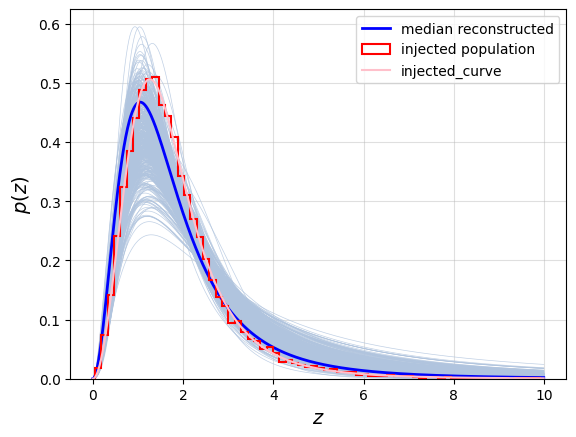

In [59]:
for i in posterior_prob_arr_list:
    plt.plot(z_grid, i, alpha=0.8, c='lightsteelblue', lw=0.5)
plt.plot(z_grid, posterior_median_prob_arr_mf, label='median reconstructed', c='b', lw=2)
plt.hist(injected_redshift, bins=70, density=True, color='r', histtype=u'step', lw=1.5, label='injected population');
plt.plot(z_grid, MDR_model.probability(dataset={'redshift':z_grid}, 
                                       **injected_hyper_params['after_time_delay']), 
         label='injected_curve', c='pink', lw=1.5)
#plt.axvline(1.9, c='k', label='$z_{peak}^{inj}$ before time delay')
plt.legend(loc=1)
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$p(z)$', fontsize=14)
plt.grid(alpha=0.4)
plt.savefig(os.path.join(run_dir, 'reconstructed_z.png'), dpi=300)

### Plot prior bands

In [ ]:
n_samples = 500
prior_samples = gwpop_result.priors.sample(n_samples)
prior_sample_records = pd.DataFrame(prior_samples).to_dict(orient='records')

: 

In [ ]:
prior_prob_arr_list = []
for rec in prior_sample_records:
    prior_prob_arr_list.append(MDR_model.probability(dataset={'redshift':z_grid}, **rec))

: 

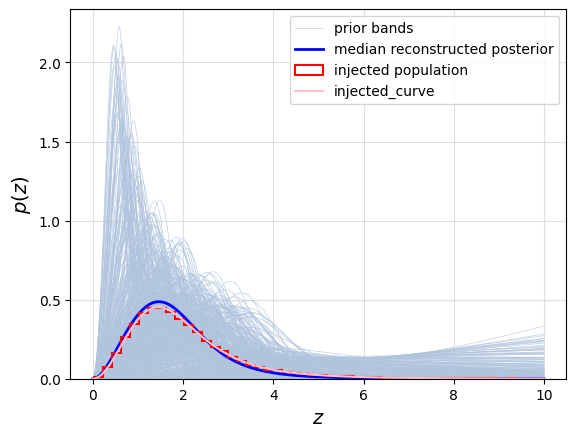

: 

In [ ]:
for j, i in enumerate(prior_prob_arr_list):
    if j == 0:
        plt.plot(z_grid, i, alpha=0.8, c='lightsteelblue', lw=0.5, label='prior bands')
    else:
        plt.plot(z_grid, i, alpha=0.8, c='lightsteelblue', lw=0.5)
plt.plot(z_grid, posterior_median_prob_arr_mf, label='median reconstructed posterior', c='b', lw=2)
plt.hist(injected_redshift, bins=50, density=True, color='r', histtype=u'step', lw=1.5, label='injected population');
plt.plot(z_grid, MDR_model.probability(dataset={'redshift':z_grid}, 
                                       **injected_hyper_params['after_time_delay']), 
         label='injected_curve', c='pink', lw=1.5)
#plt.axvline(1.9, c='k', label='$z_{peak}^{inj}$ before time delay')
plt.legend(loc=1)
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$p(z)$', fontsize=14)
plt.grid(alpha=0.4)

# CE4020ET123

In [111]:
project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
mass_band = 'below_40'
#mass_band = '40-80'
#mass_band = 'above_80'
if 'mass_band' in locals():
    print('Running for mass_band', mass_band)
    run_dir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 
                           'CE4020ET123', 'mass_bands', mass_band, 'run09_gwfish_MDhigh_mf_from_gaussian_SNR_injections_XPHM')
else:
    run_dir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 
                           'CE4020ET123', 'run24_gwfish_MDlow_mf_from_gaussian_SNR_injections_XPHM')
print(run_dir)

Running for mass_band below_40
/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/gwpop_analysis_results/CE4020ET123/mass_bands/below_40/run09_gwfish_MDhigh_mf_from_gaussian_SNR_injections_XPHM


In [112]:
gwpop_result_mf_injs = bilby.result.read_in_result(filename=os.path.join(run_dir, 
                                                                         'CE4020ET123_result.hdf5'))
posterior_mf = gwpop_result_mf_injs.posterior

In [113]:
posterior_mf

,gamma,kappa,log_likelihood,log_prior,z_peak
0,1.490873,4.946636,32175.420372,-5.857933,2.388636
1,1.672842,5.448802,32175.711810,-5.857933,2.607006
2,2.029580,5.279643,32176.479296,-5.857933,2.053218
3,1.491224,5.892035,32177.068525,-5.857933,2.609099
4,2.092219,5.965708,32177.406665,-5.857933,2.247301
...,...,...,...,...,...
3200,1.858505,5.548207,32185.496264,-5.857933,2.356738
3201,1.837310,5.500499,32185.496484,-5.857933,2.356196
3202,1.842388,5.507606,32185.502152,-5.857933,2.355021
3203,1.828140,5.525374,32185.515295,-5.857933,2.374880


In [114]:
if 'MDlow' in run_dir:
    pop_str = '5_pop_set2_PLP_spin_prec_fref_5_z_MDlow_zp_1.54_zmax_10_lmrd_22_365_days_corrected_td.h5'
elif 'MDhigh' in run_dir:
    pop_str = '4_pop_PLP_spin_prec_fref_5_z_MDhigh_zp_2.53_zmax_10_lmrd_22_365_days_corrected_td.h5'
else:
    pop_str = '2_pop_PLP_spin_prec_z_MD_zmax_10_lmrd_22_365_days_corrected_td.h5'
with h5py.File(os.path.join(project_dir, 
                            'input_population', 
                            'BBH', 
                            pop_str), 'r') as f:
    injected_redshift = f['redshift'][:]

## Plot injected data

Text(0.5, 0, '$z$')

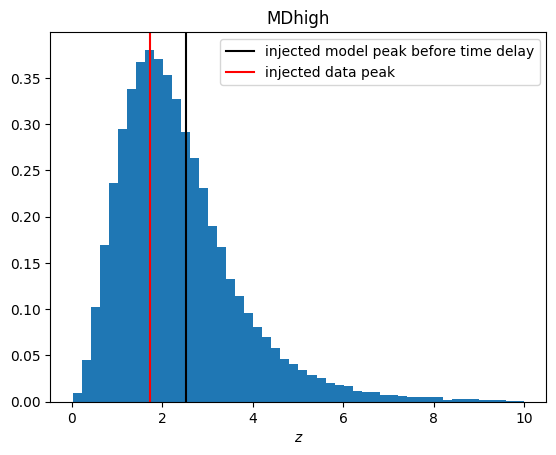

In [115]:
if 'MDhigh' in run_dir:
    inj_peak = 2.53
elif 'MDlow' in run_dir:
    inj_peak = 1.54
else:
    inj_peak = 1.9
plt.hist(injected_redshift, bins=50, density=True);
plt.axvline(inj_peak, c='k', label='injected model peak before time delay')
hData = np.histogram(injected_redshift, bins=50)
inj_z_peak_edge_idx = np.argmax(hData[0])
inj_z_peak = (hData[1][inj_z_peak_edge_idx] + hData[1][inj_z_peak_edge_idx + 1])/2
plt.axvline(inj_z_peak, c='r', label='injected data peak')
plt.legend()
plt.title(pop_str.split('_z_')[-1].split('_')[0])
plt.xlabel('$z$')

## Rebuild MDR model

In [116]:
MDR_model = MadauDickinsonRedshift(z_max=10)

In [117]:
if 'MDhigh' in run_dir:
    injected_hyper_params = {'before_time_delay':{"gamma": 2.7, "kappa": 5.6, "z_peak": 2.53}, 
                             'after_time_delay':{'gamma':1.7982, 'kappa':5.3226, 'z_peak':2.4199}}
elif 'MDlow' in run_dir:
    injected_hyper_params = {'before_time_delay':{"gamma": 2.7, "kappa": 5.6, "z_peak": 1.54}, 
                             'after_time_delay':{'gamma':1.8111, 'kappa':5.2753, 'z_peak':1.4917}}
else:
    injected_hyper_params = {'before_time_delay':{"gamma": 2.7, "kappa": 5.6, "z_peak": 1.9}, 
                             'after_time_delay':{'gamma':1.8032, 'kappa':5.3023, 'z_peak':1.8362}}

## MF SNR injections

### Plot model at injection params vs median params

In [118]:
median_hyper_params_mf = {'gamma':np.median(posterior_mf['gamma']), 
                       'kappa':np.median(posterior_mf['kappa']), 
                       'z_peak':np.median(posterior_mf['z_peak'])}

In [119]:
sort_idx = np.argsort(injected_redshift)
inj_prob_arr = MDR_model.probability(dataset={'redshift':injected_redshift}, **injected_hyper_params['before_time_delay'])
z_grid = np.arange(0, 10, 0.01)
posterior_median_prob_arr_mf = MDR_model.probability(dataset={'redshift':z_grid}, **median_hyper_params_mf)

### Plot posterior bands

In [120]:
n_samples = 500
sample_idxs = np.random.choice(np.arange(len(posterior_mf['z_peak'])), n_samples, replace=False)
sample_params = {param:posterior_mf[param][sample_idxs] for param in ['gamma', 'kappa', 'z_peak']}
sample_params_records = pd.DataFrame(sample_params).to_dict(orient='records')

In [121]:
z_grid = np.arange(0, 10, 0.01)
posterior_prob_arr_list = []
for rec in sample_params_records:
    posterior_prob_arr_list.append(MDR_model.probability(dataset={'redshift':z_grid}, **rec))

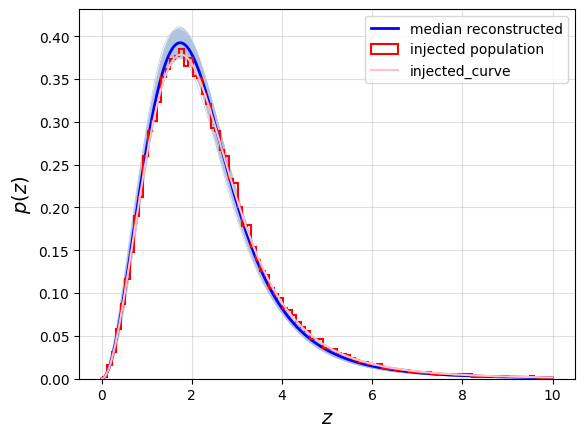

In [122]:
for i in posterior_prob_arr_list:
    plt.plot(z_grid, i, alpha=0.8, c='lightsteelblue', lw=0.5)
plt.plot(z_grid, posterior_median_prob_arr_mf, label='median reconstructed', c='b', lw=2)
plt.hist(injected_redshift, bins=100, density=True, color='r', histtype=u'step', lw=1.5, label='injected population');
plt.plot(z_grid, MDR_model.probability(dataset={'redshift':z_grid}, 
                                       **injected_hyper_params['after_time_delay']), 
         label='injected_curve', c='pink', lw=1.5)
#plt.axvline(1.9, c='k', label='$z_{peak}^{inj}$ before time delay')
plt.legend()
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$p(z)$', fontsize=14)
plt.grid(alpha=0.4)
plt.savefig(os.path.join(run_dir, 'reconstructed_z.png'), dpi=300)